<a href="https://colab.research.google.com/github/Trimmer23/IB_IA_2022/blob/main/FinalProject/Final_Project_Team3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CONVOLUTIONAL NEURAL NETWORK FOR BRAIN TUMOR DETECTION

# Team #3
* **Gerardo Asael Trimmer López #1991899**
*  **Monserrat Nogueda Hernández #1877366**
*  **José Brayan Linares Gutiérrez #1992112**
*  **Samantha Itzel Salinas Sáenz 1845889**
*  **José Alejandro Luna Martínez #1919562**
*  **Guillermo Lazarín Cardenas #1991867**

# Libray importing

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import SGD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
plt.style.use('default')
from sklearn.utils import shuffle
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

# Database importing form Keggle

In [ ]:
#install kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files 
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gerardotrimmer","key":"610d3692b2744ae676f35051817f8f07"}'}

In [ ]:
#create a kaggle folder
! mkdir ~/.kaggle


In [ ]:
#Copy kaggle.json to folder created
! cp kaggle.json ~/.kaggle/

In [ ]:
#Permission from the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ahmedhamada0/brain-tumor-detection

 87% 73.0M/84.0M [00:00<00:00, 128MB/s]
100% 84.0M/84.0M [00:00<00:00, 145MB/s]


In [ ]:
!unzip brain-tumor-detection.zip

Archive:  brain-tumor-detection.zip
  inflating: Br35H-Mask-RCNN/TEST/annotations_test.json  
  inflating: Br35H-Mask-RCNN/TEST/y701.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y702.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y703.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y704.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y705.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y706.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y707.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y708.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y709.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y710.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y711.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y712.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y713.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y714.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y715.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y716.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y717.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y718.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y719.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y720.jpg  
  infl

# Preprocessing of dataset


Firs we declare the One Hot Encoder, this will encode labels in 0 - Tumor and 1 - No Tumor

In [ ]:
encoder = OneHotEncoder()
encoder.fit([[0],[1]])

OneHotEncoder()

**Here we arrive to the part were we have to split our dataset into train and test in a randomizated way**

Now we create three lists so we are able to standarize the size of each image

*   Images for store data 
*   OHEs for store one hot encoded form of the classes
*   Paths for store paths of each image





In [ ]:
#Extraction of data from folder with images with tumor
images = []
OHEs = []
paths = []

for r, d, f in os.walk(r'../content/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((150,150))
    img = np.array(img)
    if(img.shape == (150,150,3)):
        images.append(np.array(img))
        OHEs.append(encoder.transform([[0]]).toarray())


In [ ]:
#Extraction of data from folder with images without tumor
#We recreate the list paths in order to overwrite it, images and OHEs is the same so we want all the data and label togather
paths = []

for r, d, f in os.walk(r'../content/no'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((150,150))
    img = np.array(img)
    if(img.shape == (150,150,3)):
        images.append(np.array(img))
        OHEs.append(encoder.transform([[1]]).toarray())

In [ ]:
#The data is now converted into np arrays since the model will be reciving as an input this shape
images = np.array(images)
OHEs = np.array(OHEs)

In [ ]:
#Extraction of data from folder with unlabeld images
#Again paths is recreated but we create new list for the prediction images so they are totaly independent from the model
img_Pred = []
paths = []

for r, d, f in os.walk(r'../content/pred'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((150,150))
    img = np.array(img)
    if(img.shape == (150,150,3)):
        img_Pred.append(np.array(img))
#Prediction images become a np array
img_Pred = np.array(img_Pred)

In [ ]:
#We ask for the shape of our training images 
images.shape

(2891, 150, 150, 3)

In [ ]:
#As the function says we reshape the labels with the number previously asked and also write the quantity of labels
OHEs = OHEs.reshape(2891,2)

In [ ]:
#Here, four arrays are created 2 arrays with imges and 2 with labels, spliting the data in two (Train and Test) 
#The argument test_size is the division rate, 10% in this case for test images
img_train,img_test,OHE_train,OHE_test = train_test_split(images ,OHEs, test_size=0.1, shuffle=True, random_state=0)

# Convolutional Neural Network model creation 

In [ ]:
model = Sequential()
#Here is where the layer of neurons are created
#32 Filters with size 2x2, Data size 150x150x3
model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(150, 150, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))

#Herein we normalize the data since is more efficent for the model, reducing the time training epochs take
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#Dropout for avoding overfitting
model.add(Dropout(0.25))

#64 Filters of 2x2
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

#Converting the images into one dimentional array
model.add(Flatten())

#Output layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
#This last line of code we use only a 2 because there are only 2 possible outputs (0 - Tumor, 1 - No Tumor)
model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", 
              optimizer='Adam', 
              metrics=['accuracy'])
#And now we print the summary of everything we coded
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4128      
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        8

In [ ]:
#The function ReduceLROnPlatau controls the learning rate(LR) when the validation accuracy does't change after 2 epochs (patience=2)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)    

In [ ]:
#Here we train de model with the function .fit and create the CNN named model (model.fit)
#We give as an arguments the images and OHEs of the training data, we set a validation split batch of 10%  and we call the the LR
#History will display the procces
history = model.fit(img_train,OHE_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
                   callbacks=[reduce_lr])

Epoch 1/15
74/74 [==============================] - 203s 3s/step - loss: 10.3280 - accuracy: 0.7786 - val_loss: 2.1774 - val_accuracy: 0.8276 - lr: 0.0010
Epoch 2/15
74/74 [==============================] - 203s 3s/step - loss: 0.9139 - accuracy: 0.8778 - val_loss: 0.5477 - val_accuracy: 0.8621 - lr: 0.0010
Epoch 3/15
74/74 [==============================] - 201s 3s/step - loss: 0.2219 - accuracy: 0.9308 - val_loss: 0.4052 - val_accuracy: 0.9004 - lr: 0.0010
Epoch 4/15
74/74 [==============================] - 201s 3s/step - loss: 0.1403 - accuracy: 0.9577 - val_loss: 0.1730 - val_accuracy: 0.9387 - lr: 0.0010
Epoch 5/15
74/74 [==============================] - 199s 3s/step - loss: 0.0888 - accuracy: 0.9684 - val_loss: 0.2806 - val_accuracy: 0.9272 - lr: 0.0010
Epoch 6/15
74/74 [==============================] - 192s 3s/step - loss: 0.0740 - accuracy: 0.9786 - val_loss: 0.1391 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 7/15
74/74 [==============================] - 191s 3s/step - loss: 0.

# Results

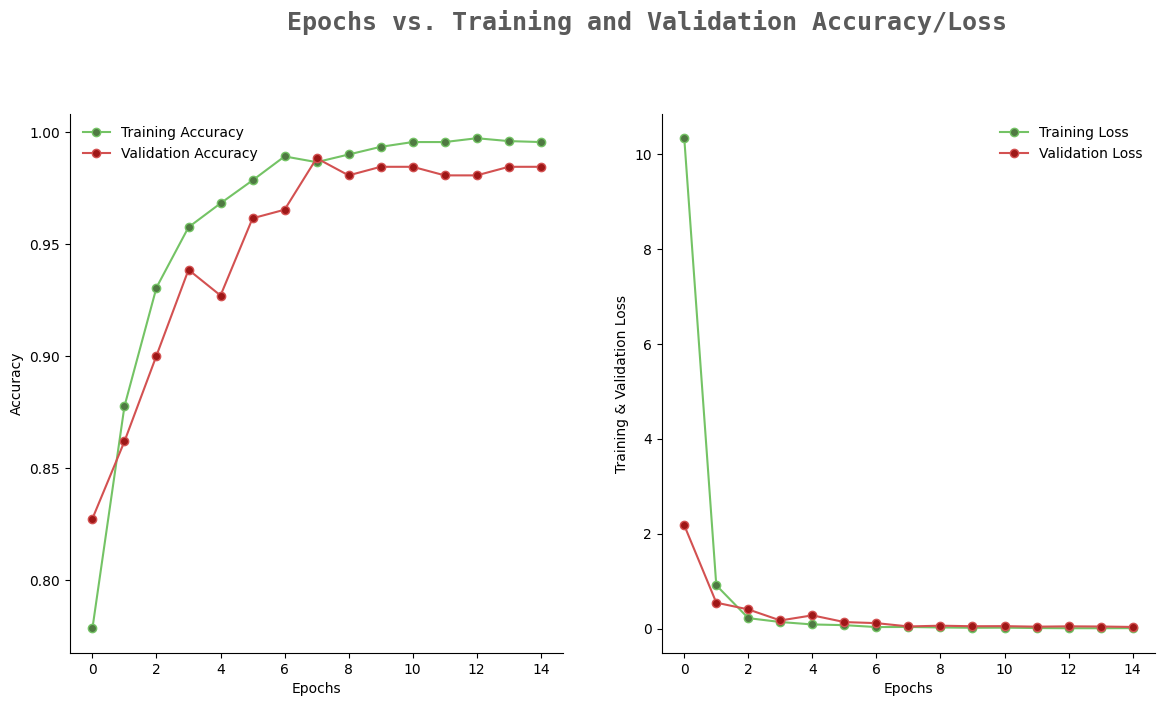

In [ ]:
# This block of code is the matplotlib charts of accuracy and loss of our training
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
epochs = [i for i in range(15)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
#A function names is created for printing the result later
def names(number):
    if number==0:
        return 'Brain MRI with tumor'
    if number==1:
        return 'Brain MRI with no tumor'

In [ ]:
#Here we see that our test data are 290 images with size 150x150 and 3 channels
img_test.shape

(290, 150, 150, 3)

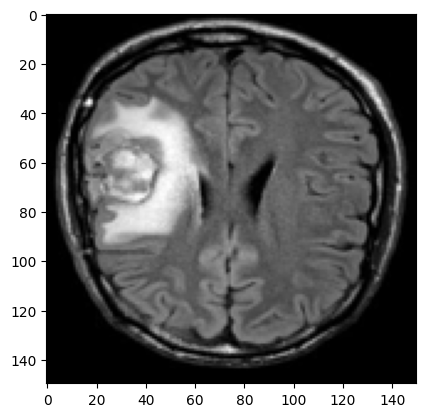

99.85135197639465% Confidence in Brain MRI with tumor

              Label: 'Tumor' 
 


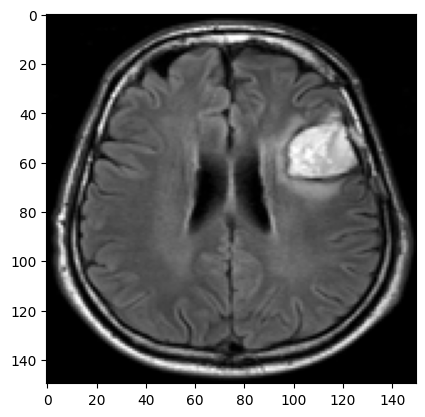

99.655282497406% Confidence in Brain MRI with tumor

              Label: 'Tumor' 
 


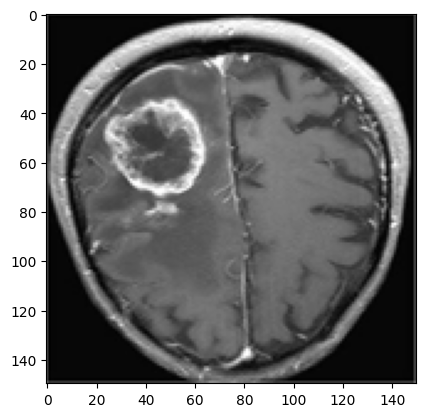

99.99465942382812% Confidence in Brain MRI with tumor

              Label: 'Tumor' 
 


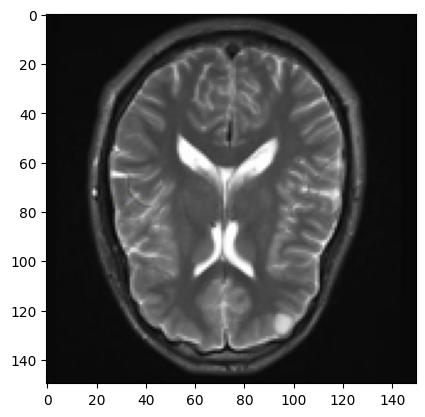

100.0% Confidence in Brain MRI with no tumor

              Label: 'No Tumor' 


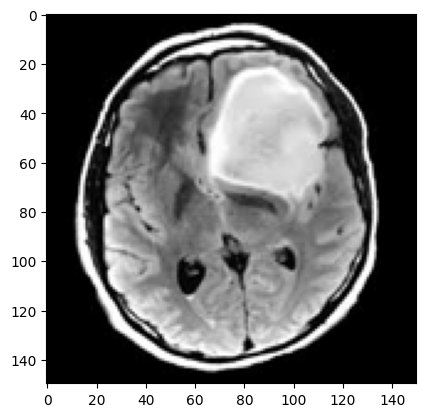

100.0% Confidence in Brain MRI with tumor

              Label: 'Tumor' 
 


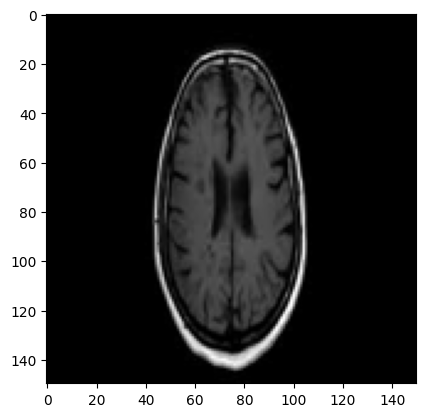

100.0% Confidence in Brain MRI with no tumor

              Label: 'No Tumor' 


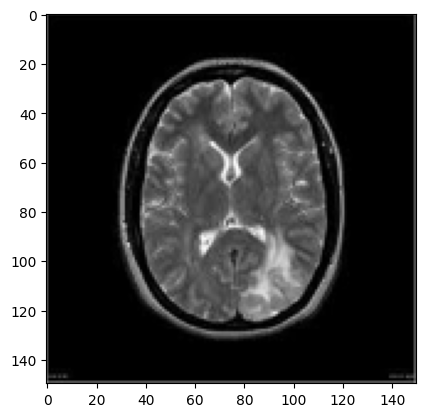

100.0% Confidence in Brain MRI with no tumor

              Label: 'No Tumor' 


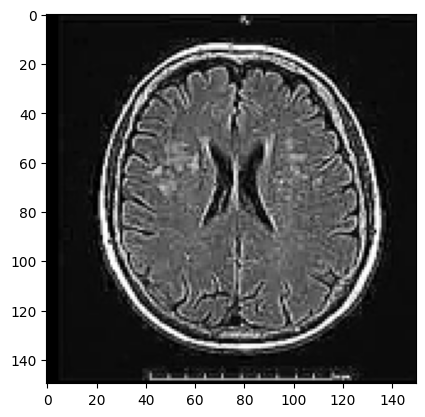

100.0% Confidence in Brain MRI with no tumor

              Label: 'No Tumor' 


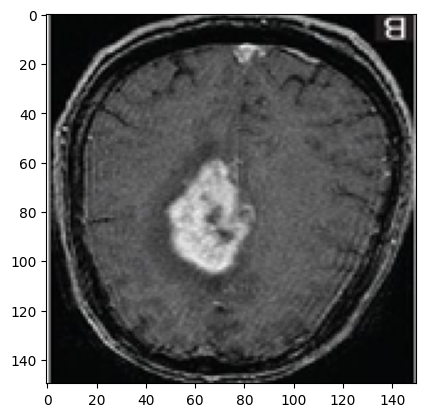

99.99953508377075% Confidence in Brain MRI with tumor

              Label: 'Tumor' 
 


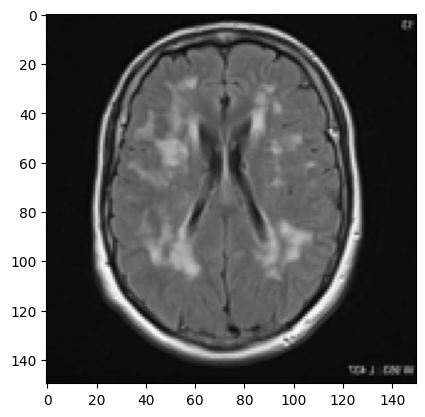

100.0% Confidence in Brain MRI with no tumor

              Label: 'No Tumor' 


In [ ]:
#This is the prediction with our testing data which we know the label of, displaying 10 random predictions with the label
from matplotlib.pyplot import imshow, show
import random

z = random.sample(range(1, 290), 10)
for i in range(10):
  img = img_test[z[i-1]]
  x = np.array(img)
  x = x.reshape(1,150,150,3)
  res = model.predict_on_batch(x)
  classification = np.where(res == np.amax(res))[1][0]
  imshow(img)
  show()
  print(str(res[0][classification]*100) + '% Confidence in ' + names(classification))
  if str(OHE_test[z[i-1]]) == '[0. 1.]':
    print("\n              Label: 'No Tumor' ")
  if str(OHE_test[z[i-1]]) == '[1. 0.]':
    print("\n              Label: 'Tumor' \n ")
  print("===================================================")

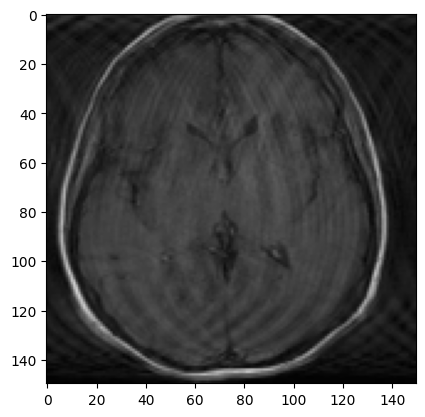

99.99090433120728% Confidence in Brain MRI with no tumor

              Label: 'Unknown' 
 


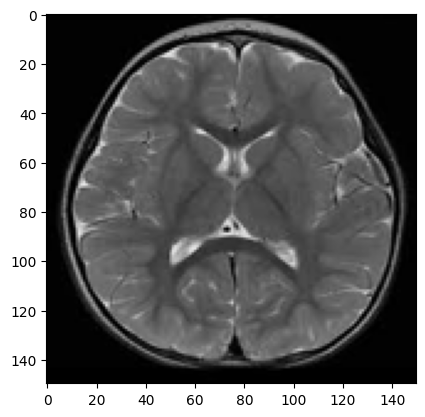

100.0% Confidence in Brain MRI with no tumor

              Label: 'Unknown' 
 


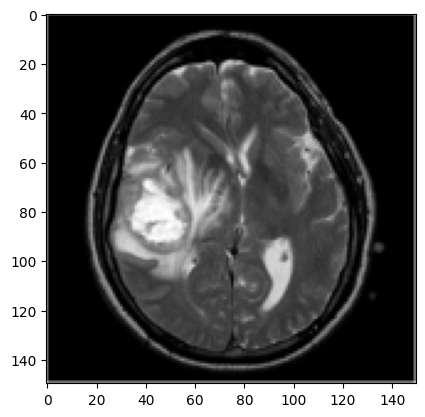

97.19840288162231% Confidence in Brain MRI with tumor

              Label: 'Unknown' 
 


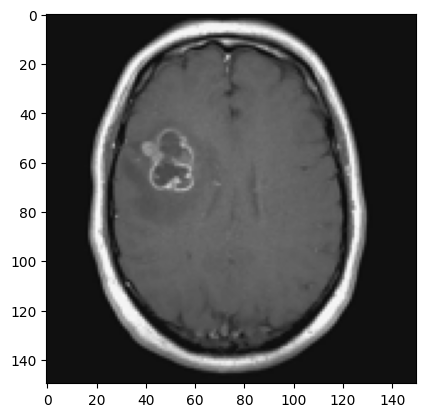

99.99666213989258% Confidence in Brain MRI with tumor

              Label: 'Unknown' 
 


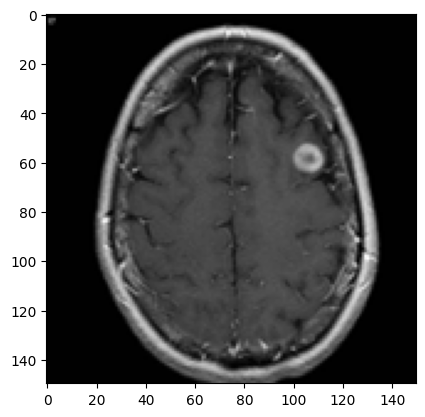

99.90548491477966% Confidence in Brain MRI with tumor

              Label: 'Unknown' 
 


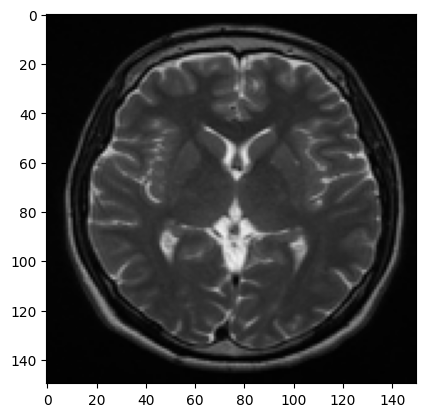

99.99998807907104% Confidence in Brain MRI with no tumor

              Label: 'Unknown' 
 


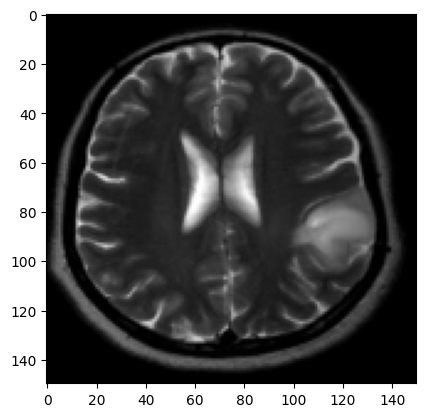

99.99988079071045% Confidence in Brain MRI with no tumor

              Label: 'Unknown' 
 


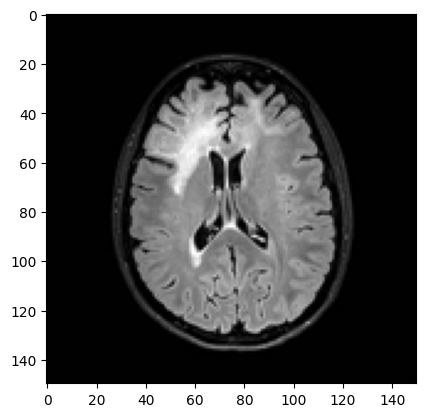

100.0% Confidence in Brain MRI with no tumor

              Label: 'Unknown' 
 


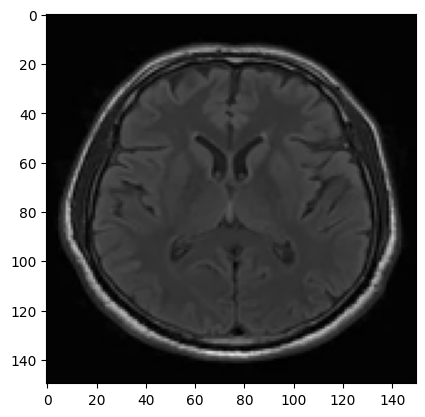

99.69431757926941% Confidence in Brain MRI with no tumor

              Label: 'Unknown' 
 


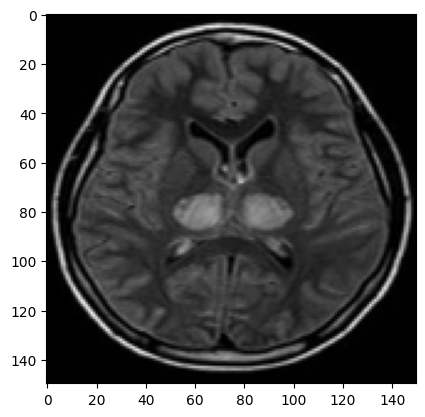

99.99985694885254% Confidence in Brain MRI with tumor

              Label: 'Unknown' 
 


In [ ]:
#And these are predictions with the data that we dont know the label of
z = random.sample(range(1, 56), 10)
for i in range(10):
  img = img_Pred[z[i-1]]
  x = np.array(img)
  x = x.reshape(1,150,150,3)
  res = model.predict_on_batch(x)
  classification = np.where(res == np.amax(res))[1][0]
  imshow(img)
  show()
  print(str(res[0][classification]*100) + '% Confidence in ' + names(classification))
  print("\n              Label: 'Unknown' \n ")
  print("===================================================")

In [ ]:
img_Pred.shape

(56, 150, 150, 3)